C:\Crystallography\_3_analysis\Monoliths_analysis\201910_11-ID-B\APS_Oct19_HKUST_mapping\constrained\d200_ML1_posh-34_1_posv-10_2-000063_tif_A0.gr
C:\Crystallography\_3_analysis\Monoliths_analysis\201910_11-ID-B\APS_Oct19_HKUST_mapping\constrained\d200_ML1_posh-34_1_posv-10_7-000062_tif_A0.gr
C:\Crystallography\_3_analysis\Monoliths_analysis\201910_11-ID-B\APS_Oct19_HKUST_mapping\constrained\d200_ML1_posh-34_1_posv-11_2-000061_tif_A0.gr
C:\Crystallography\_3_analysis\Monoliths_analysis\201910_11-ID-B\APS_Oct19_HKUST_mapping\constrained\d200_ML1_posh-34_1_posv-7_7-000068_tif_A0.gr
C:\Crystallography\_3_analysis\Monoliths_analysis\201910_11-ID-B\APS_Oct19_HKUST_mapping\constrained\d200_ML1_posh-34_1_posv-8_2-000067_tif_A0.gr
C:\Crystallography\_3_analysis\Monoliths_analysis\201910_11-ID-B\APS_Oct19_HKUST_mapping\constrained\d200_ML1_posh-34_1_posv-8_7-000066_tif_A0.gr
C:\Crystallography\_3_analysis\Monoliths_analysis\201910_11-ID-B\APS_Oct19_HKUST_mapping\constrained\d200_ML1_posh-34_1_p

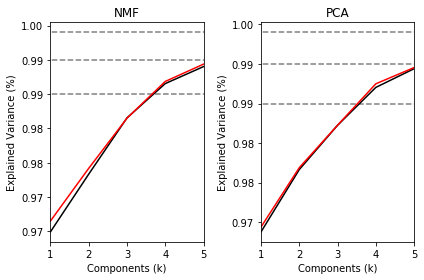

In [12]:
###############################
# 201912_11-ID-B_mail-in COFs #
# Data Processing             #
# Daniel O'Nolan              #
###############################

from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import os, sys, glob

#################
# Set file path #
#################
path =r'C:\Crystallography\_3_analysis\Monoliths_analysis\201910_11-ID-B\APS_Oct19_HKUST_mapping\constrained\\'
os.chdir(path)

##################################################
# For each PDF file, normalise, and append to df #
##################################################
PDF_files = glob.glob(path + "/*.gr")
list3 = []
for filename1 in PDF_files:
    df = np.genfromtxt(filename1, usecols=1, delimiter=' ', skip_header=int(26))
    ndf = (df-df.min())/(df.max()-df.min())
    list3.append(ndf)
    print(filename1)
PDF = pd.DataFrame(np.array(list3).T, index=['R{}'.format(i) for i in range(len(ndf))])

############################
# Set component test range #
############################
y = np.arange(1,6,1)

#############################################
# split the dataset, to measure overfitting #
#############################################
X_train, X_test = model_selection.train_test_split(PDF, test_size=0.2, random_state=1)

def get_score(model, data, scorer=metrics.explained_variance_score):# 1-(var(data-model)/var(model))
    #Estimate performance of the model on the data
    prediction = model.inverse_transform(model.transform(data))
    return scorer(data, prediction)

perfs_train = []
perfs_test = []
pca_train = []
pca_test = []
for k in y:
    nmf = decomposition.NMF(n_components=k,max_iter=10000).fit(X_train)
    perfs_train.append(get_score(nmf, X_train))
    perfs_test.append(get_score(nmf, X_test))
    pca = decomposition.PCA(n_components=k).fit(X_train)
    pca_train.append(get_score(pca, X_train))
    pca_test.append(get_score(pca, X_test))

#######################    
# NMF/PCA test output #
#######################
d = {'NMF (train)': perfs_train, 'NMF (test)': perfs_test,
     'PCA (train)': pca_train, 'PCA (test)': pca_test}
df = pd.DataFrame(data=d)
np.savetxt(r'NMF+PCA Component.csv', df, delimiter=',',header='NMF (train),NMF (test),PCA (train),PCA(test)')
print(df)

#############################
# NMF/PCA test illustration #
#############################
fig, (ax0,ax1) = plt.subplots(ncols=2,nrows=1)
ax0.set_title('NMF')
ax0.plot(y,perfs_train,'k')
ax0.plot(y,perfs_test,'r')
ax0.hlines(0.99,0,y.max(),colors='k', linestyles='--', alpha=0.5)
ax0.hlines(0.995,0,y.max(),colors='k', linestyles='--', alpha=0.5)
ax0.hlines(0.999,0,y.max(),colors='k', linestyles='--', alpha=0.5)
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax0.set_ylabel('Explained Variance (%)')
ax0.set_xlabel('Components (k)')
ax0.set_xlim(y.min(),y.max())

ax1.set_title('PCA')
ax1.plot(y,pca_train,'k')
ax1.plot(y,pca_test,'r')
ax1.hlines(0.99,0,y.max(),colors='k', linestyles='--', alpha=0.5)
ax1.hlines(0.995,0,y.max(),colors='k', linestyles='--', alpha=0.5)
ax1.hlines(0.999,0,y.max(),colors='k', linestyles='--', alpha=0.5)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_ylabel('Explained Variance (%)')
ax1.set_xlabel('Components (k)')
ax1.set_xlim(y.min(),y.max())
fig.tight_layout()
plt.savefig(r'NMF+PCA Component.tif', bbox_inches='tight', dpi=600)
plt.show()

###########
# Run NMF #
###########
r = (df['NMF (test)'] - 0.98).apply(abs).idxmin()+1
mod = decomposition.NMF(n_components=r,max_iter=2000)
W = pd.DataFrame(mod.fit_transform(PDF))
H = pd.DataFrame(mod.components_)

np.savetxt(r'W.csv', W, delimiter=',')
np.savetxt(r'H.csv', H, delimiter=',')
    

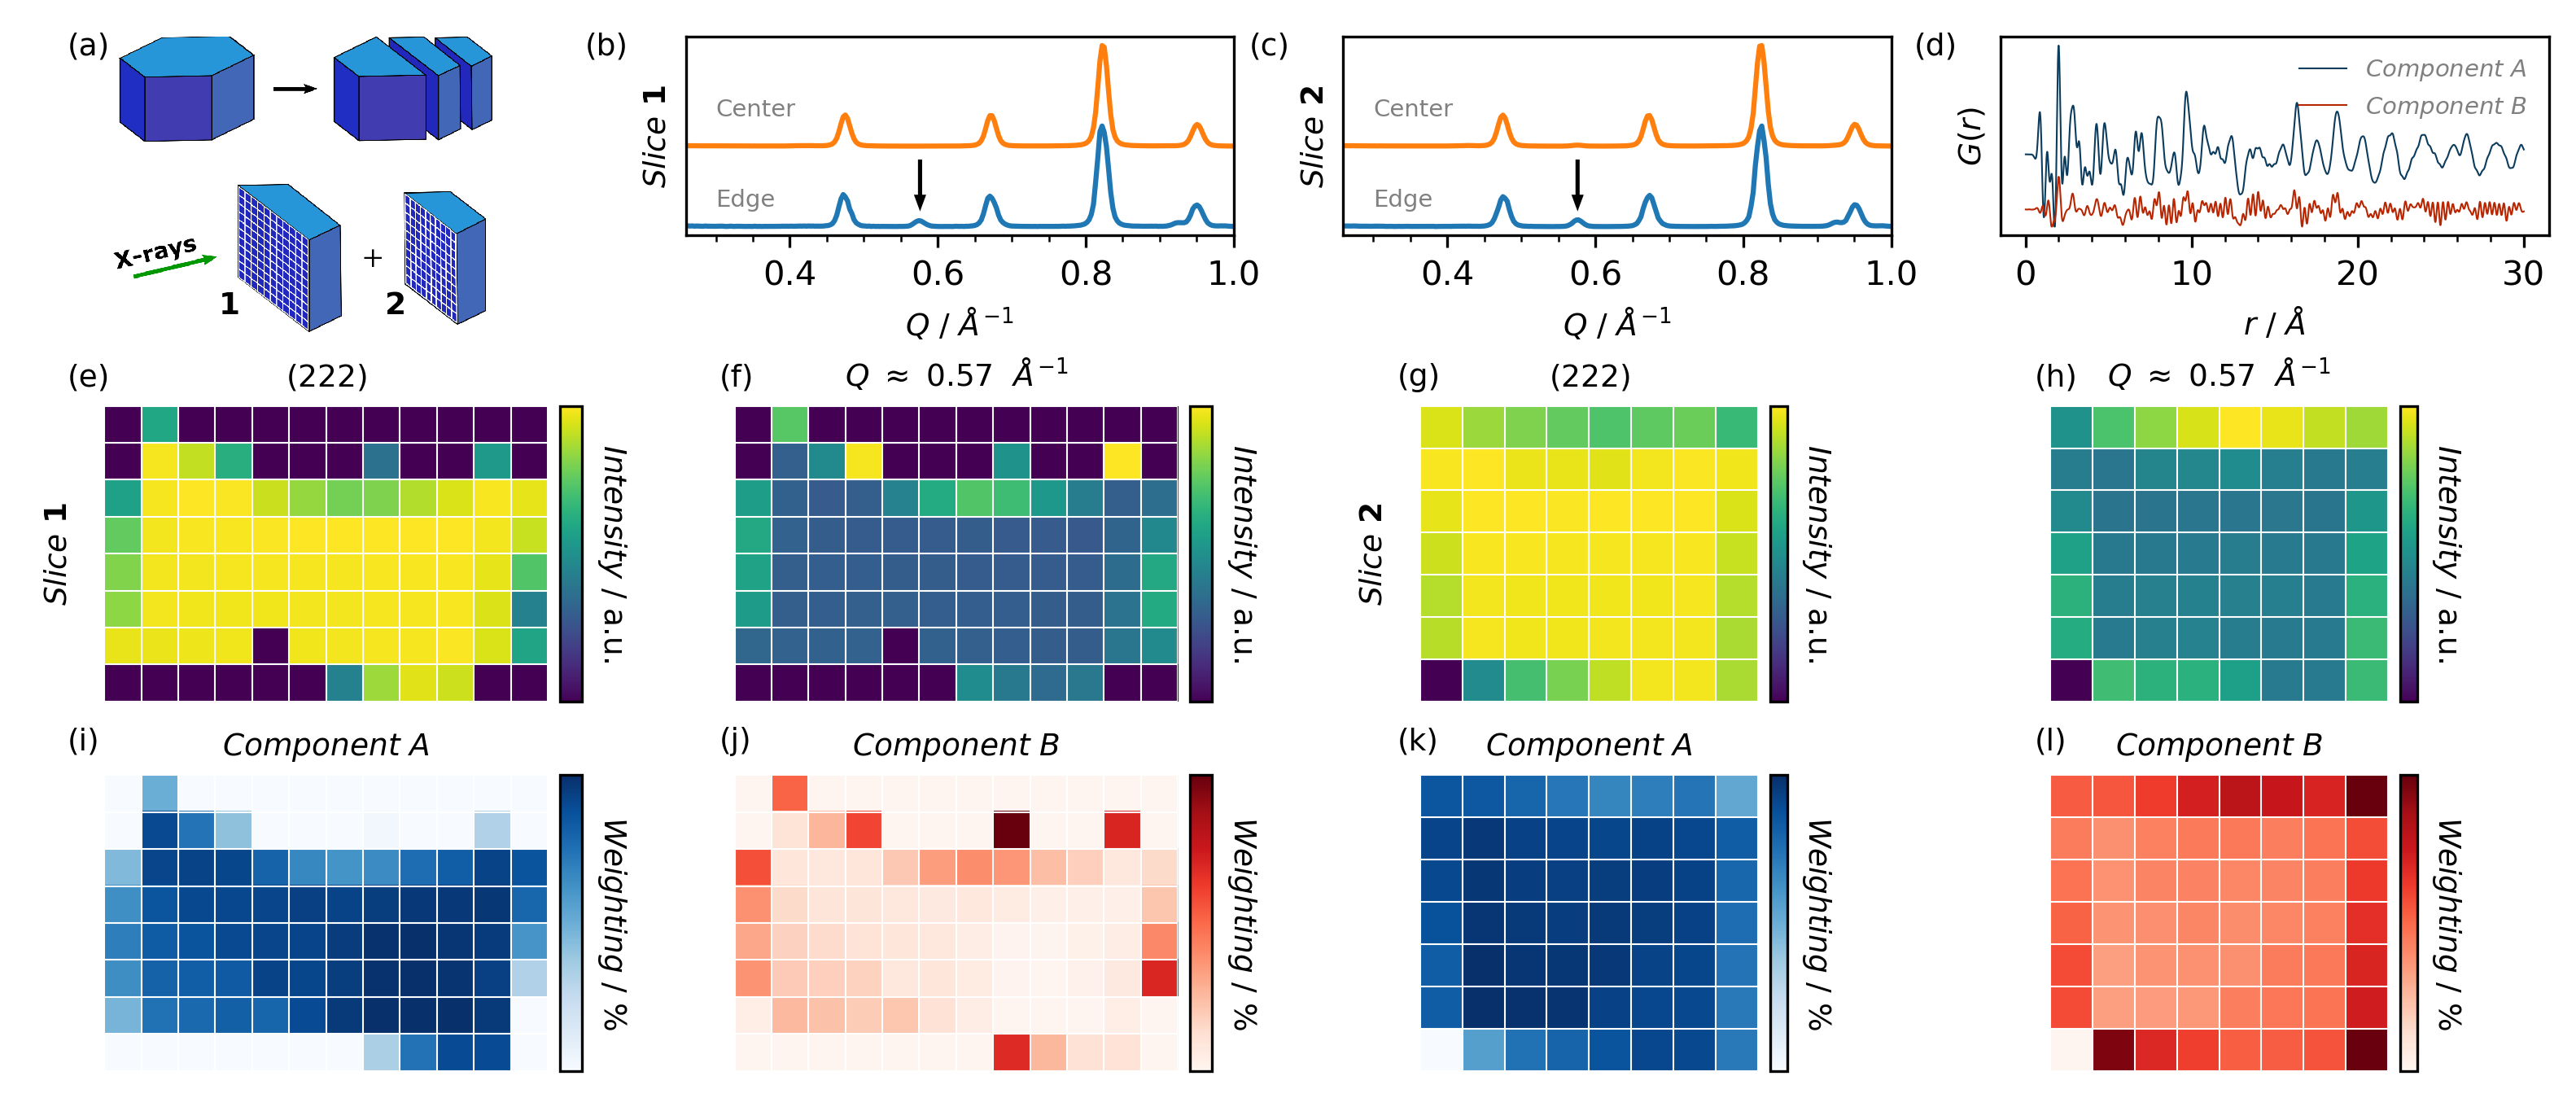

In [71]:
## # Heatmaps    #
# D. O'Nolan  #
###############
import pandas as pd
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import os, sys, glob

path =r'C:\Crystallography\_3_analysis\Monoliths_analysis\\'
os.chdir(path)

#########
# Fig b #
#########
XRD_files = glob.glob(path + r"201910_11-ID-B\APS_Oct19_HKUST_mapping\re-do\ml1_xrd_contour" + "/*.chi")
list1 = []
for filename0 in XRD_files:
    df = np.genfromtxt(filename0, usecols=1, delimiter='   ', skip_header=int(4))
    list1.append(df)
    #print(filename0)
XRD = pd.DataFrame(np.array(list1).T, index=['R{}'.format(i) for i in range(len(df))])
tth = np.genfromtxt(r"201910_11-ID-B\APS_Oct19_HKUST_mapping\re-do\ml1_xrd_contour\01.chi",delimiter='   ', usecols=0, skip_header=int(4))

nXRD = (XRD-XRD.min())/(XRD.max()-XRD.min())
Q=((4*((np.pi))*(np.sin(np.deg2rad(tth/2))))/0.2115)
Y=np.arange(1,16,1)

#########
# Fig c #
#########
XRD_files1 = glob.glob(path + r"201910_11-ID-B\APS_Oct19_HKUST_mapping\re-do\ml2_xrd_contour" + "/*.chi")
list2 = []
for filename1 in XRD_files1:
    df1 = np.genfromtxt(filename1, usecols=1, delimiter='   ', skip_header=int(4))
    list2.append(df1)
    #print(filename1)
XRD1 = pd.DataFrame(np.array(list2).T, index=['R{}'.format(i) for i in range(len(df1))])
tth1 = np.genfromtxt(r"201910_11-ID-B\APS_Oct19_HKUST_mapping\re-do\ml2_xrd_contour\01.chi",delimiter='   ', usecols=0, skip_header=int(4))

nXRD1 = (XRD1-XRD1.min())/(XRD1.max()-XRD1.min())
Q1=((4*((np.pi))*(np.sin(np.deg2rad(tth1/2))))/0.2115)
Y1=np.arange(1,20,1)

#########
# Fig d #
#########
r = np.arange(0.01,30.02,0.01)
A = np.genfromtxt(r'201910_11-ID-B\APS_Oct19_HKUST_mapping\re-do\NMF\W.csv',delimiter=',',usecols=0)
B = np.genfromtxt(r'201910_11-ID-B\APS_Oct19_HKUST_mapping\re-do\NMF\W.csv',delimiter=',',usecols=1)

#########
ml1area_files = glob.glob(path + r"201910_11-ID-B\APS_Oct19_HKUST_mapping\re-do" + "/*chi.chi")
for filename2 in ml1area_files:
    I = np.genfromtxt(filename2, usecols=1, delimiter='   ', skip_header=int(4)) #length = 1540 bins
    hkl = integrate.cumtrapz(I[90:125])
    #y = print(filename2, "= hkl =", hkl[-1])
ml1area_files = glob.glob(path + r"201910_11-ID-B\APS_Oct19_HKUST_mapping\re-do" + "/*chi.chi")
for filename2 in ml1area_files:
    I = np.genfromtxt(filename2, usecols=1, delimiter='   ', skip_header=int(4)) #length = 1540 bins    
    twotwotwo =  integrate.cumtrapz(I[161:223])
    #z = print(filename2, "= 222 =", twotwotwo[-1])

#########
vertical1 = ["","","","","","",""]
horizontal1 = ["","","","","","","",""]

vertical2 = ["","","","","","","",""]
horizontal2 = ["","","","","","","","","","","",""]

#########
# Fig e #
#########
#	                   7.7	 8.2   8.7	 9.2   9.7	10.2  10.7	11.2
ML1_222 = np.array([[0.945,0.850,0.807,0.761,0.723,0.751,0.776,0.673], #34.1
                    [0.989,1.000,0.969,0.967,0.956,0.982,0.994,0.980], #34.6
                    [0.961,0.997,0.998,0.996,0.998,0.999,1.000,0.942], #35.1
                    [0.923,0.990,0.990,0.985,0.986,0.985,0.992,0.916], #35.6
                    [0.888,0.982,0.980,0.979,0.979,0.980,0.986,0.888], #36.1
                    [0.893,0.986,0.977,0.979,0.981,0.982,0.984,0.873], #36.6
                    [0.000,0.481,0.706,0.800,0.903,0.982,0.984,0.873]]) #37.1

#########
# Fig f #
#########
#	                   7.7	 8.2   8.7	 9.2   9.7	10.2  10.7	11.2
ML1_hkl = np.array([[0.512,0.717,0.830,0.939,1.000,0.965,0.909,0.857], #34.1
                    [0.423,0.391,0.456,0.463,0.487,0.433,0.406,0.429], #34.6
                    [0.479,0.386,0.385,0.391,0.393,0.395,0.388,0.528], #35.1
                    [0.573,0.403,0.405,0.415,0.419,0.417,0.404,0.579], #35.6
                    [0.641,0.421,0.434,0.439,0.437,0.433,0.411,0.640], #36.1
                    [0.618,0.410,0.436,0.444,0.424,0.417,0.410,0.680], #36.6
                    [0.000,0.692,0.641,0.637,0.563,0.417,0.410,0.680]]) #37.1

#########
# Fig g #
#########
#                   7.7	  8.2	8.7	  9.2	9.7	 10.2  10.7	 11.2
ML1A = np.array([[0.692,0.684,0.643,0.588,0.543,0.564,0.596,0.428], #34.1
                 [0.746,0.783,0.756,0.745,0.739,0.750,0.736,0.670], #34.6
                 [0.731,0.787,0.763,0.757,0.766,0.763,0.752,0.640], #35.1
                 [0.703,0.788,0.779,0.765,0.777,0.767,0.755,0.618], #35.6
                 [0.669,0.810,0.788,0.785,0.783,0.747,0.739,0.599], #36.1
                 [0.669,0.808,0.803,0.795,0.754,0.737,0.732,0.581], #36.6
                 [0.000,0.457,0.606,0.648,0.697,0.737,0.732,0.581]]) #37.1

#########
# Fig h #
#########
#	                7.7	  8.2	8.7	  9.2	9.7	 10.2  10.7	 11.2
ML1B = np.array([[0.308,0.316,0.357,0.412,0.457,0.436,0.404,0.572], #34.1
                 [0.254,0.217,0.244,0.255,0.261,0.250,0.264,0.330], #34.6
                 [0.269,0.213,0.237,0.243,0.234,0.237,0.248,0.360], #35.1
                 [0.297,0.212,0.221,0.235,0.223,0.233,0.245,0.382], #35.6
                 [0.331,0.190,0.212,0.215,0.217,0.253,0.261,0.401], #36.1
                 [0.331,0.192,0.197,0.205,0.246,0.263,0.268,0.419], #36.6
                 [0.000,0.543,0.394,0.352,0.303,0.305,0.321,0.569]]) #37.1

#########
# Fig i #
#########
#                      7.9	 8.4   8.9	 9.4   9.9	10.4  10.9	11.4  11.9	12.4  12.9	13.4
ML2_222 = np.array([[0.000,0.598,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000], #52.0
                    [0.000,0.988,0.909,0.632,0.000,0.000,0.000,0.378,0.000,0.000,0.540,0.000], #52.5
                    [0.571,0.987,1.000,0.995,0.921,0.840,0.791,0.806,0.884,0.943,0.989,0.963], #53.0
                    [0.760,0.982,0.990,0.991,0.993,0.997,0.998,1.000,0.999,0.999,0.982,0.917], #53.5
                    [0.811,0.982,0.981,0.985,0.987,0.988,0.988,0.991,0.992,0.992,0.964,0.728], #53.0
                    [0.829,0.984,0.980,0.979,0.978,0.982,0.984,0.985,0.986,0.989,0.946,0.440], #54.5
                    [0.968,0.972,0.976,0.978,0.000,0.979,0.982,0.988,0.987,0.993,0.943,0.583], #55.0
                    [0.000,0.000,0.000,0.000,0.000,0.000,0.438,0.854,0.955,0.923,0.000,0.000]]) #55.5

#########
# Fig j #
#########
#                      7.9	 8.4   8.9	 9.4   9.9	10.4  10.9	11.4  11.9	12.4  12.9	13.4
ML2_hkl = np.array([[0.000,0.741,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000], #52.0
                    [0.000,0.306,0.473,0.987,0.000,0.000,0.000,0.513,0.000,0.000,1.000,0.000], #52.5
                    [0.559,0.310,0.289,0.301,0.445,0.615,0.729,0.691,0.535,0.418,0.301,0.360], #53.0
                    [0.603,0.316,0.294,0.292,0.291,0.291,0.293,0.289,0.288,0.281,0.324,0.465], #53.5 
                    [0.576,0.302,0.300,0.297,0.294,0.294,0.292,0.292,0.290,0.291,0.352,0.604], #53.0
                    [0.553,0.301,0.300,0.306,0.307,0.299,0.300,0.298,0.296,0.296,0.381,0.612], #54.5 
                    [0.332,0.315,0.309,0.313,0.000,0.310,0.306,0.297,0.294,0.293,0.392,0.480], #55.0
                    [0.000,0.000,0.000,0.000,0.000,0.000,0.485,0.406,0.348,0.399,0.000,0.000]]) #55.5

#########
# Fig k #
#########
#                   7.9	  8.4	8.9	  9.4	9.9	 10.4  10.9	 11.4  11.9	 12.4  12.9	 13.4
ML2A = np.array([[0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000], #52.0
                 [0.000,0.900,0.742,0.414,0.000,0.000,0.000,0.024,0.000,0.000,0.317,0.000], #52.5
                 [0.447,0.915,0.924,0.914,0.801,0.666,0.615,0.646,0.764,0.824,0.922,0.861], #53.0
                 [0.633,0.859,0.905,0.910,0.917,0.934,0.925,0.949,0.967,0.966,0.972,0.790], #53.5
                 [0.697,0.831,0.863,0.899,0.916,0.920,0.952,0.989,0.996,0.976,0.957,0.606], #53.0
                 [0.638,0.808,0.822,0.836,0.923,0.914,0.949,0.989,1.000,0.978,0.935,0.318], #54.5
                 [0.470,0.749,0.778,0.813,0.794,0.892,0.958,1.000,1.000,1.000,0.961,0.000], #55.0
                 [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.334,0.745,0.891,0.894,0.000]]) #55.5

#########
# Fig l #
#########
#	                7.9	  8.4	8.9	  9.4	9.9	 10.4  10.9	 11.4  11.9	 12.4  12.9	 13.4
ML2B = np.array([[0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000], #52.0
                 [0.000,0.100,0.258,0.586,0.000,0.000,0.000,0.976,0.000,0.000,0.683,0.000], #52.5
                 [0.553,0.085,0.076,0.086,0.199,0.334,0.385,0.354,0.236,0.176,0.078,0.139], #53.0
                 [0.367,0.141,0.095,0.090,0.083,0.066,0.075,0.051,0.033,0.034,0.028,0.210], #53.5
                 [0.303,0.169,0.137,0.101,0.084,0.080,0.048,0.011,0.004,0.024,0.043,0.394], #53.0
                 [0.362,0.192,0.178,0.164,0.077,0.086,0.051,0.011,0.000,0.022,0.065,0.682], #54.5
                 [0.039,0.251,0.222,0.187,0.206,0.108,0.042,0.000,0.000,0.000,0.039,0.000], #55.0
                 [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.666,0.255,0.109,0.106,0.000]]) #55.5

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()
    im = ax.imshow(data, **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = ax.figure.colorbar(im, cax=cax, ax=ax, format='',ticks=[],aspect=20, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=9)
    ax.set_xticks([])#(np.arange(data.shape[1]))
    ax.set_yticks([])#(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.
    kw = dict(horizontalalignment="center", 
              verticalalignment="center")
    kw.update(textkw)

    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts

f = plt.figure(dpi=300)
f.set_figheight(1.87*3)
f.set_figwidth(3.33*4)
gs0 = gridspec.GridSpec(3, 1, figure=f, hspace=0.25,wspace=0)
G00 = gridspec.GridSpecFromSubplotSpec(nrows=16,ncols=4, subplot_spec=gs0[0], hspace=2,wspace=0.2)
ax00 = plt.subplot(G00[0:16,0:1])
ax02 = plt.subplot(G00[0:11,1:2])
ax01 = plt.subplot(G00[0:11,2:3])
ax03 = plt.subplot(G00[0:11,3:4])

G01 = gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=4, subplot_spec=gs0[1], wspace=0)
ax04 = plt.subplot(G01[0,0:1])
ax05 = plt.subplot(G01[0,1:2])
ax06 = plt.subplot(G01[0,2:3])
ax07 = plt.subplot(G01[0,3:4])

G02 = gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=4, subplot_spec=gs0[2], wspace=0)
ax08 = plt.subplot(G02[0,0:1])
ax09 = plt.subplot(G02[0,1:2])
ax10 = plt.subplot(G02[0,2:3])
ax11 = plt.subplot(G02[0,3:4])


## part a ##
ax00.axis('off')
Figa = mpimg.imread('g10475.png')
ax00.imshow(Figa)
## part b ##
ax01.plot(Q, nXRD[0])
ax01.plot(Q, nXRD[10]+0.8)
ax01.set_xlim(0.25924805,1)
ax01.set_yticks([])
ax01.minorticks_on()
ax01.set_xlabel(r'$\it{Q}$ / $\AA^{-1}$', fontsize=9)
ax01.set_ylabel(r'$\it{Slice}$ 2', fontsize=9, fontweight='bold')
## part c ##
ax02.plot(Q, nXRD1[7])
ax02.plot(Q, nXRD1[10]+0.8)
ax02.set_xlim(0.25924805,1)
ax02.set_yticks([])
ax02.minorticks_on()
ax02.set_xlabel(r'$\it{Q}$ / $\AA^{-1}$', fontsize=9)
ax02.set_ylabel(r'$\it{Slice}$ 1', fontsize=9, fontweight='bold')
## part d ##
ax03.plot(r, A, linewidth=0.5, color='#0B3C5D', label=r'$\it{Component}$ $\it{A}$')
ax03.plot(r, B, linewidth=0.5, color='#B82601', label=r'$\it{Component}$ $\it{B}$')
ax03.set_yticks(())
ax03.minorticks_on()
l = ax03.legend(loc=1, frameon=False,markerscale=3, fontsize=7)
for text in l.get_texts():
    text.set_color('#808080')
ax03.set_xlabel(r'$\it{r}$ / $\AA$', fontsize=9)
ax03.set_ylabel(r'$\it{G(r)}$', fontsize=9)
## part e ##
im, cbar = heatmap(ML1_222, horizontal1, vertical1, ax=ax06, vmax=1,cmap="viridis", cbarlabel=r"$\it{Intensity}$ / a.u.")
ax06.set_title(r'$\it{(222)}$', fontsize=9)
ax06.set_ylabel(r'$\it{Slice}$ 2', fontsize=9, fontweight='bold')
## part f ##
im, cbar = heatmap(ML1_hkl, horizontal1, vertical1, ax=ax07, vmax=1,cmap="viridis", cbarlabel=r"$\it{Intensity}$ / a.u.")
ax07.set_title(r'$\it{Q}$ $\approx$ 0.57  $\AA^{-1}$', fontsize=9)
## part g ##
im, cbar = heatmap(ML1A, horizontal1, vertical1, ax=ax10,cmap="Blues", cbarlabel=r"$\it{Weighting}$ / %")
ax10.set_title(r'$\it{Component}$ $\it{A}$', fontsize=9)
## part h ##
im, cbar = heatmap(ML1B, horizontal1, vertical1, ax=ax11,cmap="Reds", cbarlabel=r"$\it{Weighting}$ / %")
ax11.set_title(r'$\it{Component}$ $\it{B}$', fontsize=9)
## part i ##
im, cbar = heatmap(ML2_222, horizontal1, vertical1, ax=ax04, vmax=1,cmap="viridis", cbarlabel=r"$\it{Intensity}$ / a.u.")
ax04.set_title(r'$\it{(222)}$', fontsize=9)
ax04.set_ylabel(r'$\it{Slice}$ 1', fontsize=9, fontweight='bold')
## part j ##
im, cbar = heatmap(ML2_hkl, horizontal1, vertical1, ax=ax05, vmax=1,cmap="viridis", cbarlabel=r"$\it{Intensity}$ / a.u.")
ax05.set_title(r'$\it{Q}$ $\approx$ 0.57  $\AA^{-1}$', fontsize=9)
## part k ##
im, cbar = heatmap(ML2A, horizontal2, vertical2, ax=ax08,cmap="Blues", cbarlabel=r"$\it{Weighting}$ / %")
ax08.set_title(r'$\it{Component}$ $\it{A}$', fontsize=9)
## part l ##
im, cbar = heatmap(ML2B, horizontal2, vertical2, ax=ax09,cmap="Reds", cbarlabel=r"$\it{Weighting}$ / %")
ax09.set_title(r'$\it{Component}$ $\it{B}$', fontsize=9)

ax04.text(-1.5,-10,'(a)', fontsize=9)
ax04.text(12.5,-10,'(b)', fontsize=9)
ax04.text(30.5,-10,'(c)', fontsize=9)
ax04.text(48.5,-10,'(d)', fontsize=9)

ax04.text(-1.5,-1.05,'(e)', fontsize=9)
ax04.text(16.15,-1.05,'(f)', fontsize=9)
ax04.text(34.5,-1.05,'(g)', fontsize=9)
ax04.text(51.75,-1.05,'(h)', fontsize=9)

ax04.text(-1.5,8.8,'(i)', fontsize=9)
ax04.text(16.15,8.8,'(j)', fontsize=9)
ax04.text(34.5,8.8,'(k)', fontsize=9)
ax04.text(51.75,8.8,'(l)', fontsize=9)

ax04.text(2.6,-3,'1', fontsize=9,fontweight='bold')
ax04.text(7.1,-3,'2', fontsize=9,fontweight='bold')
ax01.text(0.3,0.2,'Edge', fontsize=7,color='#808080')
ax01.text(0.3,1.1,'Center', fontsize=7,color='#808080')
ax02.text(0.3,0.2,'Edge', fontsize=7,color='#808080')
ax02.text(0.3,1.1,'Center', fontsize=7,color='#808080')

ax01.arrow(0.576,0.65,0,-0.45, shape='full', length_includes_head=True,
           lw=1, head_width=0.01, head_length=0.1, color='k')
ax02.arrow(0.576,0.65,0,-0.45, shape='full', length_includes_head=True,
           lw=1, head_width=0.01, head_length=0.1, color='k')


plt.savefig(r'201910_11-ID-B\APS_Oct19_HKUST_mapping\re-do\20200618_Dan_HKUST-1_Maps2.tif',
            bbox_inches='tight')
plt.show()

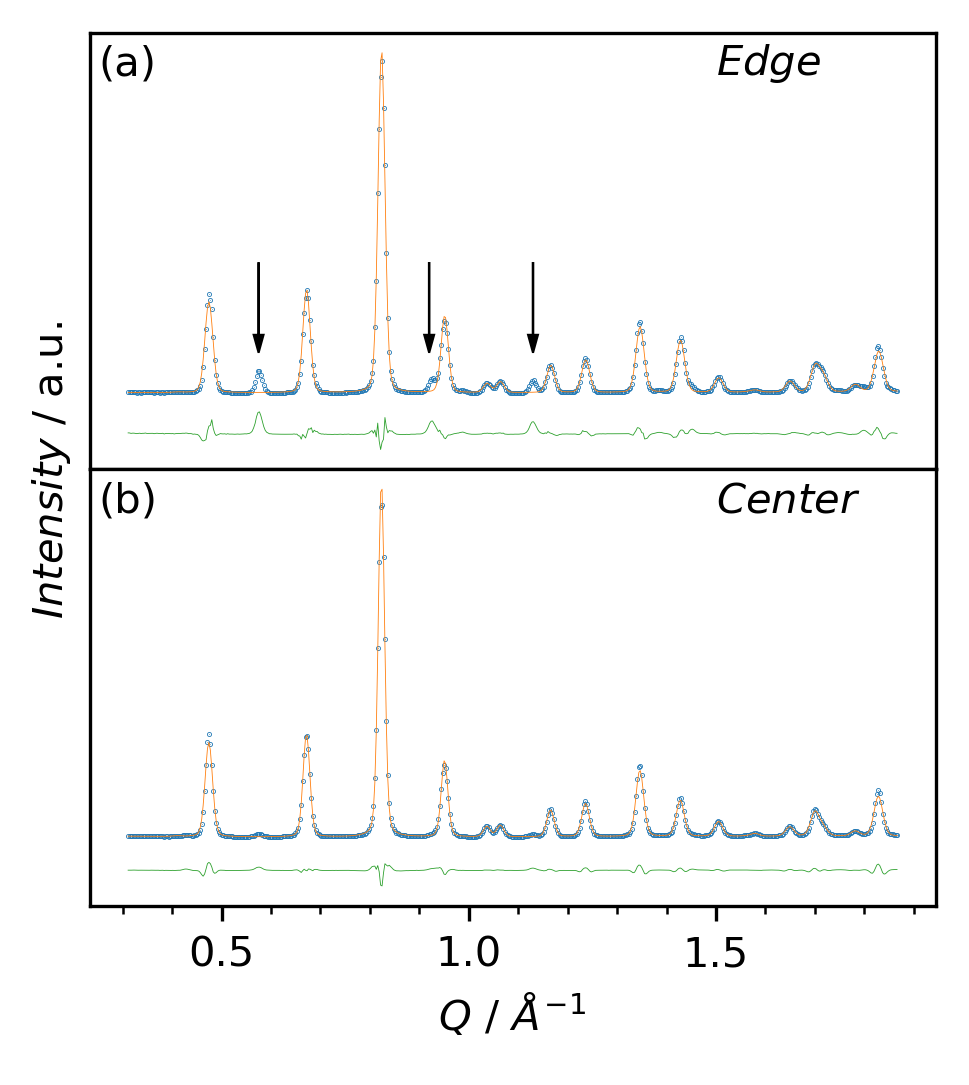

In [70]:
## # Heatmaps    #
# D. O'Nolan  #
###############
import pandas as pd
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os, sys, glob

path =r'F:\2020_Chapman_ONolan_monoHKUST1\xye\\'
os.chdir(path)
a = "LeBail_d950_ML1_posh-34_1_posv-8_2-000067_tif_A0.YYD.csv"
b = "LeBail_d950_ML1_posh-36_1_posv-9_2-000025_tif_A0.YYD.csv"

x = np.linspace(0.6,3.6,534)
wavelength=0.2115
q=((4*((np.pi))*(np.sin(np.deg2rad(x/2))))/wavelength)

a_obs = np.genfromtxt(a,delimiter=',',usecols=0)
a_cal = np.genfromtxt(a,delimiter=',',usecols=1)
a_dif = np.genfromtxt(a,delimiter=',',usecols=2)

b_obs = np.genfromtxt(b,delimiter=',',usecols=0)
b_cal = np.genfromtxt(b,delimiter=',',usecols=1)
b_dif = np.genfromtxt(b,delimiter=',',usecols=2)

f = plt.figure(dpi=300)
f.set_figheight(1.87*2)
f.set_figwidth(3.33*1)
gs0 = gridspec.GridSpec(1, 1, figure=f, hspace=0,wspace=0)
G00 = gridspec.GridSpecFromSubplotSpec(nrows=2,ncols=1, subplot_spec=gs0[0], hspace=0,wspace=0)
ax00 = plt.subplot(G00[0:1,0])
ax00.plot(q,a_obs, 'o', markersize=0.2)
ax00.plot(q,a_cal, linewidth=0.2)
ax00.plot(q,a_dif-2000, linewidth=0.2)
ax00.set_xticks(())
ax00.set_yticks(())
ax00.text(0.25, 18000, '(a)')
ax00.text(1.5, 18000, '$\it{Edge}$')
ax00.arrow(0.575,7500,0,-5000, shape='full', length_includes_head=True,
           lw=0.5, head_width=0.02, head_length=1000, color='k')
ax00.arrow(0.92,7500,0,-5000, shape='full', length_includes_head=True,
           lw=0.5, head_width=0.02, head_length=1000, color='k')
ax00.arrow(1.13,7500,0,-5000, shape='full', length_includes_head=True,
           lw=0.5, head_width=0.02, head_length=1000, color='k')

ax01 = plt.subplot(G00[1:2,0])
ax01.plot(q,b_obs, 'o', markersize=0.2)
ax01.plot(q,b_cal, linewidth=0.2)
ax01.plot(q,b_dif-4000, linewidth=0.2)
ax01.set_yticks(())
ax01.minorticks_on()
ax01.text(0.25, 44000, '(b)')
ax01.text(1.5, 44000, '$\it{Center}$')
ax01.set_xlabel(r'$\it{Q}$ / ${\AA^{-1}}$')
ax01.set_ylabel(r'                                 $\it{Intensity}$ / a.u.')
f.tight_layout()
plt.savefig(r'20200618_Dan_monoHKUST_RietveldFits.tif', bbox_inches='tight')
plt.show()